#  Create custom deployments with `ibm-watson-machine-learning`

This notebook facilitates Pytorch ML library in Watson Machine Learning service. It contains steps and code to work with [ibm-watson-machine-learning](https://pypi.python.org/pypi/ibm-watson-machine-learning) library available in PyPI repository. It also introduces commands for creating and deploying a custom fucntion.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Learning goals

The learning goals of this notebook are:

-  Create a custom python function 
-  Persist the function model in Watson Machine Learning repository.
-  Deploy function for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Create a custom python function](#download)
3.	[Persist the function model](#persistence)
4.	[Deploy and score in a Cloud](#scoring)
5.  [Clean up](#cleanup)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = ''
location = ''

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [3]:
!pip install -U ibm-watson-machine-learning

Requirement already up-to-date: ibm-watson-machine-learning in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.22)


In [4]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

2020-10-09 13:12:11,714 - ibm_watson_machine_learning.wml_client_error - WARNING - deployment deletion failed. Reason: {"trace":"9326f9277c0d3d69ee40430a99d350f2","errors":[{"code":"deployment_does_not_exist","message":"Deployment of name '89098410-5ed9-4d55-9f45-8b81fa829e0f' doesn't exist. Cannot retrieve non existing deployment"}]} 
2020-10-09 13:27:34,041 - ibm_watson_machine_learning.wml_client_error - WARNING - Artifact with artifact_uid: '7aab0814-148c-491e-b6dd-dc8b61173eb2' does not exist.
2020-10-09 13:29:03,772 - ibm_watson_machine_learning.wml_client_error - WARNING - deployment deletion failed. Reason: {"trace":"2d98dc9ecd06902110ad2bf1a43b7d01","errors":[{"code":"deployment_does_not_exist","message":"Deployment of name '89098410-5ed9-4d55-9f45-8b81fa829e0f' doesn't exist. Cannot retrieve non existing deployment"}]} 
2020-10-09 13:41:51,691 - ibm_watson_machine_learning.wml_client_error - WARNING - Failure during scoring. (POST https://us-south.ml.cloud.ibm.com/ml/v4/deplo

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
space_id = ''

In [ ]:
client.spaces.get_details(space_id)

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [8]:
client.set.default_space(space_id)

'SUCCESS'

<a id="download"></a>
## 2. Create a custom python function
In this section, you will create a custom python function


The python fucnctions for deployment needs to have this specific format for payload_input. It is a dictionary with the key "input_data" and the key "values" that contains the records.

In [ ]:
records= ['Record1' , 'Record2' , 'Record3']
payload_input = {"input_data": [{"values": records}]}

The payload_output for deployment needs to be a dictionary with the key "predictions" and the key "values" which would contain the outputs

In [ ]:
outputs = ['Record1-changed' , 'Record2-changed' , 'Record3-changed']
payload_output = {"predictions": [{"values": outputs}]} 

### 2.1: Simple python function

In this section, we will see how to create a simple python function for deployment within WML.
This function takes the strings in the record and adds an exclaimation to the end of it.

In [ ]:
def addexclaimation():
    
    def exclaimation(payload_input):
        outputs =[]
        
        records = payload_input.get("input_data")[0].get("values")
        for record in records :
            #This is where we can preprocess each record
            outputs.append(record+"!")
               
        payload_output= {"predictions": [{"values": outputs}]}    
        return payload_output
    
    return exclaimation

We can test the functions using the code below

In [ ]:
records = ["Hello" ,"How are you doing"]
payload_input = {"input_data": [{"values": records}]}   

In [ ]:
function_result = addexclaimation()(payload_input)
print(function_result)

### 2.2: Python function with external libraries for preprocessing

In this section, we will see how to preprocess records with PyTorch torchtext using python functions using WML.
This function takes the strings in the record and converts them into a list of letters.

If we are using external libraries we need to install and import them within the functions

In [9]:
def addPreprocessing() :
    """
    Install the external libraries
    """
    import subprocess
    def install(name):
        subprocess.call(['pip', 'install', name])

    install("torch=1.6")    
    install("torchtext")

    """
    Import the external libraries
    """
    import torch
    import torchtext
    
    def preprocessing(payload_input) :
        
       
        
        
    
        records = payload_input.get("input_data")[0].get("values")
        outputs =[]
        
        TEXT = torchtext.data.Field(lower = True, batch_first = True, init_token  = '<bos>', eos_token   = '<eos>',)

        for record in records:
            record=  list(map(TEXT.preprocess, record))
            outputs.append(record)
            
        payload_output = {"predictions": [{"values": outputs}]}    
       
        return payload_output
    
    return preprocessing    

We can test the functions using the code below

In [10]:
records = ["Bat" ,"Cat"]
payload_input = {"input_data": [{"values": records}]}   

In [11]:
function_result = addPreprocessing()(payload_input)
print(function_result)

{'predictions': [{'values': [[['b'], ['a'], ['t']], [['c'], ['a'], ['t']]]}]}


### 2.3: Python function with external libraries for preprocessing and deployments

In [46]:
def addPreprocessingandScoring() :
    """
    Install the external libraries
    """
    import subprocess
    def install(name):
        subprocess.call(['pip', 'install', name])

    install("torch=1.6")    
    install("torchtext")
    install("torchvision")
    install("wget")
    
    """
    Import the external libraries
    """
    import torch
    import torch.nn as nn
    import torchtext
    import os
    import wget
    import pickle
    import types
    import pandas as pd
    from botocore.client import Config
    import ibm_boto3
    import io
    from torchvision import datasets, transforms
    import torch.nn.functional as F
        
    
    def preprocessingandscoring(payload_input) :
        
        
        
    
        """
        Read in saved .pkl for data assests
        """
        clients3 = ibm_boto3.client(service_name='s3',
            ibm_api_key_id='dKHIg3RBJ-Wais5slCJ69xifQZ_Vt1XhTxtGgr3qpH2I',
            ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
            config=Config(signature_version='oauth'),
            endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

        streamingbody = clients3.get_object(Bucket='vmwareenablement-donotdelete-pr-dfpqt0z6tem3ox', Key='model.pkl')['Body']
        model_path = io.BytesIO(streamingbody.read())
     
        
        """
        Define model corresponding to the saved weights
        """
        
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
                self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
                self.conv2_drop = nn.Dropout2d()
                self.fc1 = nn.Linear(320, 50)
                self.fc2 = nn.Linear(50, 10)

            def forward(self, x):
                x = F.relu(F.max_pool2d(self.conv1(x), 2))
                x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
                x = x.view(-1, 320)
                x = F.relu(self.fc1(x))
                x = F.dropout(x, training=self.training)
                x = self.fc2(x)
                return F.log_softmax(x)
            
        """
        Load model corresponding to the saved weights
        """    
        
        device = torch.device("cpu")
        model = Net()
        model.load_state_dict(torch.load(model_path,map_location=device))
        model.eval()
        
        """
        Preprocess records and get predictions
        """ 
    
        records = payload_input.get("input_data")[0].get("values")
        records = torch.tensor(records) 
        
        outputs= model(records.float())    
        predictions = [a.index(max(a)) for a in outputs.tolist()]
            
        payload_output = {"predictions": [{"values": predictions}]}    
       
        return payload_output
    
    return preprocessingandscoring    

To test this function lets download this MNIST data

In [47]:
!pip install wget
import os
import wget
import numpy as np

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
filename = os.path.join(data_dir, 'mnist.npz')
if not os.path.isfile(filename):
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=data_dir) 
    
dataset =  np.load(filename)
x_test = dataset['x_test']

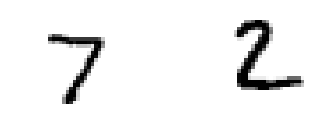

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

In [49]:
records = [[x_test[0].tolist()] ,[x_test[1].tolist()]]
payload_input = {"input_data": [{"values": records}]} 

In [50]:
function_result = addPreprocessingandScoring()(payload_input)
print(function_result)

{'predictions': [{'values': [7, 2]}]}


<a id="persistence"></a>
## 3. Persist custom python function 

In this section, you will learn how to store your function in Watson Machine Learning repository by using the IBM Watson Machine Learning SDK.

### 3.1: Publish functions

#### Publish function in Watson Machine Learning repository on Cloud.

Define model name,and software_specifications for the python function would be 'ai-function_0.1-py3.6'

In [51]:
sofware_spec_uid_function = client.software_specifications.get_id_by_name("ai-function_0.1-py3.6")

In [52]:
function_meta_props = {
         client.repository.FunctionMetaNames.NAME: 'Sample Python Function Deployment',
         client.repository.FunctionMetaNames.SOFTWARE_SPEC_ID: sofware_spec_uid_function
         }

In [53]:
function_artifact = client.repository.store_function(meta_props=function_meta_props, function=addPreprocessingandScoring)

### 3.2: Get function details

In [ ]:
function_uid = client.repository.get_function_id(function_artifact)
print("Function UID = " + function_uid)

### 3.3 Get all functions

In [88]:
 client.repository.list_functions()

----  ----  -------  ----
GUID  NAME  CREATED  TYPE
----  ----  -------  ----


In [87]:
 #client.repository.delete('')

'SUCCESS'

<a id="scoring"></a>
## 4. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the IBM Watson Machine Learning SDK.

### 4.1: Create function deployment

#### Create online deployment for published function

List all the hardware specifications available

In [59]:
client.hardware_specifications.list()

-------------  ------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------
NAME           ID                                    DESCRIPTION
ML             7a46ecc7-0ea9-4c94-a444-fbda4d6adc4a  A hardware specification providing 4 CPU cores and 32 GiB of memory.
V100x2         a02f3ab5-6964-4f06-a870-c7cc69187895  A hardware specification providing 52 CPU cores and 96 GiB of memory with 2 Nvidia v100 GPUs.
L              a6c4923b-b8e4-444c-9f43-8a7ec3020110  A hardware specification providing 8 CPU cores and 32 GiB of memory.
Default Spark  ac59d20a-9c7c-4504-a853-788ef35969da  A hardware specification for Spark with 1 CPU and 4 GiB of memory for master and worker nodes, with 2 workers.
XXS            b128f957-581d-46d0-95b6-8af5cd5be580  A hardware specification providing one CPU core and 2 GiB of memory.
M-Spark        b2232f7a-bfad-4822-9bce-6ba1af49217a  A hardware specif

In [60]:
hardware_spec_id = client.hardware_specifications.get_id_by_name('K80x2')

In [61]:
function_deploy_meta = {
     client.deployments.ConfigurationMetaNames.NAME: "Test Preprocess Deployment",
     client.deployments.ConfigurationMetaNames.ONLINE: {},
     client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: { "id": hardware_spec_id}
 }

In [62]:
function_deployment_details = client.deployments.create(function_uid, meta_props=function_deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '7903e9e5-ce59-4948-9b88-a69d0cad0f85' started

#######################################################################################


initializing............
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4dac3e01-26c7-4e06-bcce-3ef01e97c260'
------------------------------------------------------------------------------------------------




Now you can print an online scoring endpoint. 

In [ ]:
scoring_endpoint = client.deployments.get_scoring_href(function_deployment_details)
print(scoring_endpoint)

You can also list existing deployments.

In [85]:
client.deployments.list()

----  ----  -----  -------
GUID  NAME  STATE  CREATED
----  ----  -----  -------


In [84]:
#client.deployments.delete('')

'SUCCESS'

### 4.2: Get deployment details

In [66]:
function_deployment_uid = function_deployment_details['metadata']['id']

In [ ]:
client.deployments.get_details(function_deployment_uid)

### 4.3: Score

You can use below method to do test scoring request against deployed model.

In [80]:
#input = {"input_data": [{"values": ["Lets test it" , "It works"]}]}
input = {"input_data": [{"values": [[x_test[0].tolist()] ,[x_test[1].tolist()]]}]}
#input = {"input_data": [{"values": [[x_test[2].tolist()] ,[x_test[3].tolist()],[x_test[4].tolist()],[x_test[5].tolist()]]}]}
#input = {"input_data": [{"values": [[x_test[6].tolist()] ,[x_test[7].tolist()],[x_test[8].tolist()],[x_test[9].tolist()]]}]}

In [81]:
client.deployments.score(function_deployment_uid, input)

{'predictions': [{'values': [7, 2]}]}

<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook! You learned how to use Pytorch machine learning library as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html?pos=2)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Sheetal Reddy**, Data Scientist


Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.